#Ca Simulation

This notebook describes and implements a simulation of calcium imaging data for use to test source extraction methods with ground truth data.

1. Calculating kernel for GCaMP6s

In the CNMF framework, calcium transients are are generated by an AR(2) process. The appendex of [reference] shows that this model is a discrete-time approximation of a continuous model consisting of spikes convolved with a difference of exponential kernel. So to generate the simulation, the first step is to approximate the parameters of this kernel based on the measured response properties of GCaMP6s, given in [reference]. 

The kernel of the continuous process is given by 

$$h(t) = \exp \left(\frac{-t}{\tau_d} \right) - \exp \left(\frac{-t}{\tau_r} \right), $$

where $\tau_r$ is the rise time constant and $\tau_d$ is the decay time constant. [reference] lists values for the transient peak time, $t_{peak}$, and the half decay time $t_{half}$. To solve for $\tau_r$ and $\tau_d$ in terms of $\tau_{peak}$, and $\tau_{half}$, we will solve the follwing system of equations.

$$ h^{\prime} (t_{peak}) = 0$$

$$ h(t_{half}) = \frac{1}{2} h(t_{peak})$$

This system does not appear to have an analytic solution. However, by assuming that $t_{half} >> \tau_r$ so that $\exp \left( \frac{-t_{half}}{\tau_r} \right) \approx 0$, we can use the second equation to solve for $\tau_r$ in terms of $\tau_d$.

After solving for $\tau_r$ in terms of $\tau_d$, we can substitute this the solution into the first equation and use numerical methods to find the solution for $\tau_d$. We can then substitute this back into the simplified second equation to find $\tau_r$. 

This is all done below using SymPy for the algebra and scipy optimize for the numerical methods.

/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in add
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in log
  """


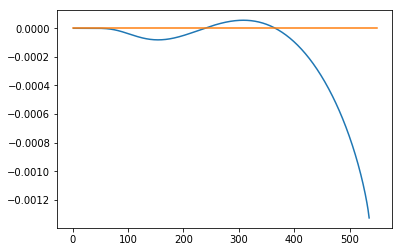

In [139]:
import sympy as sp
import numpy as np
from scipy.optimize import brentq, root, fsolve, broyden1
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
%matplotlib inline

t, tau_d, tau_r, t_peak, t_half = sp.symbols('t, tau_d, tau_r, t_peak, t_half')

def h(x):
    return sp.exp(-x/tau_d) - sp.exp(-x/tau_r)

eq1 = sp.Eq(sp.diff(h(t), t).subs(t, t_peak), 0)

eq2 = sp.Eq(sp.exp(-t_half/tau_d) - 0.5*h(t_peak), 0)

display(Math(sp.latex(eq1)))
display(Math(sp.latex(eq2)))


This is the system we will solve. Using the second equation can solve for $\tau_r$:


/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in add
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in log
  """


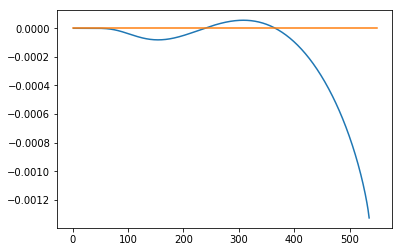

In [140]:
solutions = sp.solve(eq2, tau_r)
eq_sub = eq1.subs(tau_r, solutions[0])
display(Math(sp.latex(eq_sub)))

We can then plug in the values from the literature ($t_{peak}=179$ms and $t_{half}=550$ms). We plot the left hand side as a function of $\tau_d$ to demonstrate that the equation has two solutions for $\tau_d$. and solve for $\tau_d$ using scipy.optimize nonlinear root finder.


/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in add
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/home/pmalonis/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in log
  """


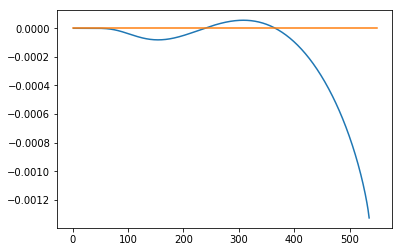

In [141]:

t_peak_val = 179
t_half_val = 550
eq_sub = eq_sub.subs({t_peak:t_peak_val, t_half:t_half_val})
f = sp.lambdify(tau_d, eq_sub.lhs)
times = np.arange(0, 1000, 1)
plt.plot(times, f(times))
plt.plot(np.arange(0,t_half_val), np.zeros(t_half_val))

We use the python nonlinear equation sovler to find the two roots of this function. The larger root can be found 

In [163]:
x0 = [200,400] #initial guesses of root
tau_d_vals = fsolve(f, x0)
tau_r_vals = np.zeros_like(tau_d_vals)
for i in range(2):
    tau_r_vals[i] = solutions[0].subs({tau_d:tau_d_vals[i], 
    t_peak:t_peak_val, 
    t_half:t_half_val})
    
print(tau_d_vals)
print(tau_r_vals)

[ 238.33273094  365.73079782]
[ 137.83173715  100.49018312]


Solution 1
	 t_peak: 179.000000
	 t_half: 489.000000
Solution 2
	 t_peak: 179.000000
	 t_half: 542.000000


/home/pmalonis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 999
  # This is added back by InteractiveShellApp.init_path()


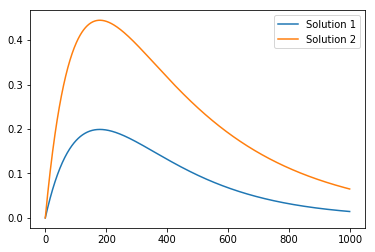

In [164]:
params = ()
for i in range(2):
    #computing calcium trace for each solution
    h_func = sp.lambdify(t, h(t).subs({tau_d:tau_d_vals[i], 
                                       tau_r:tau_r_vals[i]}))
    trace = h_func(times)
    
    #getting parameters
    half_height = np.max(trace)/2
    solved_t_half = times[np.logical_and(trace[:-1] > half_height,
                                         trace[1:] <= half_height)]
    solved_t_peak = times[np.argmax(trace)]
    plt.plot(times, trace)
    plt.legend(['Solution 1', 'Solution 2'])
    print("Solution %d"%(i+1))
    print("\t t_peak: %f"%solved_t_peak)
    print("\t t_half: %f"%solved_t_half)